## Test the splitting approach performance

In [1]:
import sys, os

sys.path.append("/gpfs/ysm/project/kleinstein/mw957/repos/spectral-tree-inference/spectraltree")

import copy
import numpy as np
import utils
import generation
import reconstruct_tree
import dendropy
import scipy
import time
from itertools import product
import matplotlib.pyplot as plt
import pandas as pd

from dendropy.model.discrete import simulate_discrete_chars, Jc69, Hky85
from dendropy.calculate.treecompare import symmetric_difference
from sklearn.decomposition import TruncatedSVD

def HKY_similarity_matrix(observations, classes=None, verbose = False):
    m, N = observations.shape
    if classes is None:
        classes = np.unique(observations)
    k = len(classes)
    # From Tamura, K., and M. Nei. 1993
    # for each pair of sequences, 
    # 1. estimate the average base frequency for pairs of sequences
    # 2. compute purine transition proportion P1 (A <-> G)
    # 3. compute pyrimidine transition proportion P2 (T <-> C)
    # 3. compute transversion proportion Q (A <-> C, A <-> T, G <-> C, G <-> T)

    if verbose: print("Computing the average base frequency for each pair of sequences...")
    g = {}
    for x in classes:
        obs_x = observations == x
        g[x] = np.array([np.mean(np.hstack([a, b])) for a, b in product(obs_x, repeat = 2)]).reshape((m, m))
    
    g["R"] = g["A"] + g["G"]
    g["Y"] = g["T"] + g["C"]
    
    # compute transition and transversion proportion
    if verbose: print("Computing transition and transversion proportion for each pair of sequences...")
    P = {}
    for i, x in enumerate(classes):
        other_classes = np.delete(classes, i)
        for y in other_classes:
            P_x_y = np.array([np.mean(np.logical_and(a == x, b == y)) for a, b in product(observations, repeat = 2)]).reshape((m, m))
            P[x + y] = P_x_y
            
    P_1 = P['AG'] + P["GA"]
    P_2 = P['CT'] + P['TC']
    Q = P['AC'] + P['CA'] + P['AT'] + P['TA'] +\
        P['GC'] + P['CG'] + P['GT'] + P['TG']

    # compute the similarity (formula 7)
    if verbose: print("Computing similarity matrix")
    R = (1 - g["R"]/(2 * g["A"] * g["G"]) * P_1 - 1 / (2 * g["R"]) * Q)
    Y = (1 - g["Y"]/(2 * g["T"] * g["C"]) * P_2 - 1 / (2 * g["Y"]) * Q)
    T = (1 - 1/(2 * g["R"] * g["Y"]) * Q)
    S = np.sign(R) * (np.abs(R))**(2 * g["A"] * g["G"] / g["R"])
    S += np.sign(Y) * (np.abs(Y))**(2 * g["T"] * g["C"] / g["Y"])
    S += np.sign(T) * (np.abs(T))**(2 * (g["R"] * g["Y"] - g["A"] * g["G"] * g["Y"] / g["R"] - g["T"] * g["C"] * g["R"] / g["Y"]))

    return S

def check_is_bipartition(tree, bool_partition):
    bipartitions = [str(x)[::-1] for x in tree.encode_bipartitions()]
    partition_1 = "".join(list(bool_partition.astype('int').astype('str')))
    partition_2 = "".join(list((1 - bool_partition).astype('int').astype('str')))
    is_bipartition = (partition_1 in bipartitions) or (partition_2 in bipartitions)
    return is_bipartition


SVD2_OBJ = TruncatedSVD(n_components=2, n_iter=7)
def svd2(mat):
    if (mat.shape[0] == 1) | (mat.shape[1] == 1):
        return 0
    elif (mat.shape[0] == 2) | (mat.shape[1] == 2):
        return np.linalg.svd(mat,False,False)[1]
    else:
        return SVD2_OBJ.fit(mat).singular_values_[1]

def partition_taxa(v,similarity,num_gaps):
    m = len(v)
    v_sort = np.sort(v)
    gaps = v_sort[1:m]-v_sort[0:m-1]
    ind_partition = np.argpartition(gaps, -num_gaps)[-num_gaps:]
    smin = 1000
    for p_idx in ind_partition:        
        threshold = (v_sort[p_idx]+v_sort[p_idx+1])/2
        if (p_idx>0) & (p_idx<m-2):
            bool_bipartition = v<threshold
            s_sliced = similarity[bool_bipartition,:]
            s_sliced = s_sliced[:,~bool_bipartition]
            s2 = svd2(s_sliced)
            if s2<smin:
                partition_min = bool_bipartition
                smin = s2
        elif p_idx == 0: partition_min = v <= v_sort[0]
        elif p_idx == m - 2: partition_min = v < v_sort[m-1]
    return partition_min

In [33]:
tree_path = "/home/mw957/project/repos/spec_tree/data/skygrid_J2.newick"
fasta_path = "/home/mw957/project/repos/spec_tree/data/H3N2_NewYork.fasta"

H3N2_tree = dendropy.Tree.get(path=tree_path, schema="newick")

In [ ]:
B = 50
N = [20, 50, 100, 1000]
mean_is_bipartition = []

for n in N:
    print(n)
    bipartitions = []
    start_time = time.time()
    for b in range(B):
        print(b)
        data_HKY = simulate_discrete_chars(n, H3N2_tree, Hky85(kappa = 2), mutation_rate=0.1)
        ch_list = list()
        for t in data_HKY.taxon_namespace: 
            ch_list.append([x.symbol for x in data_HKY[t]])
        ch_arr = np.array(ch_list)
        
        HKY_sim = HKY_similarity_matrix(ch_arr)
        _, eigvec = np.linalg.eigh(HKY_sim)
        partition = partition_taxa(eigvec[:,-2], HKY_sim, 1)
        is_bipartition = check_is_bipartition(H3N2_tree, partition)
        bipartitions.append(int(is_bipartition))
    runtime = time.time() - start_time
    print("--- %s seconds ---" % runtime)

    mean_is_bipartition.append(np.mean(bipartitions))

metrics = pd.DataFrame({"N": N, "valid partition freq": mean_is_bipartition})
metrics.to_csv("/gpfs/ysm/project/kleinstein/mw957/repos/spec_tree/script/split_metrics.csv")

In [2]:
metrics = pd.read_csv("/gpfs/ysm/project/kleinstein/mw957/repos/spec_tree/script/split_metrics.csv")
metrics.iloc[:,1:3]

,N,valid partition freq
0,50,0.66
1,100,0.82
2,400,1.00
3,600,1.00
4,800,1.00
5,1000,1.00


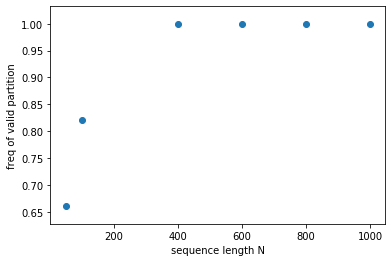

In [3]:
plt.scatter(metrics.N, metrics["valid partition freq"])
plt.xlabel("sequence length N")
plt.ylabel("freq of valid partition")
plt.show()

## Test the rooting approach

In [4]:
tree_path = "/home/mw957/project/repos/spec_tree/data/skygrid_J2.newick"
fasta_path = "/home/mw957/project/repos/spec_tree/data/H3N2_NewYork.fasta"

H3N2_tree = dendropy.Tree.get(path=tree_path, schema="newick")
all_bipartitions = np.array([str(x)[::-1] for x in H3N2_tree.encode_bipartitions()][0:-1])

taxon_namespace_label = np.array([x.label for x in H3N2_tree.taxon_namespace])

def to_bool(partition_str):
    return np.array(list(partition_str)) == '1'

def min_partition_size(bipartition_encoding):
    n_ones = np.sum(np.array(list(bipartition_encoding)) == '1')
    n_zeros = np.sum(np.array(list(bipartition_encoding)) == '0')
    return(min(n_ones, n_zeros))

min_bipar = np.array([min_partition_size(x) for x in all_bipartitions])
filtered_bipar = all_bipartitions[np.where(min_bipar > 50)[0]]

In [7]:
len(all_bipartitions)

1127

In [6]:
len(filtered_bipar)

43

43 out of 1127 bipartitions have minimum partition size > 50. Tested all 43 bipartitions. 

In [ ]:
N = [50, 100, 400, 600, 800, 1000]
Ns = []
par1s = []
par2s = []
RFs = []
F1s = []
rts = []

for n in N:
    print(n)
    data_HKY = simulate_discrete_chars(n, H3N2_tree, Hky85(kappa = 2), mutation_rate=0.1)
    ch_list = list()
    for t in data_HKY.taxon_namespace: 
        ch_list.append([x.symbol for x in data_HKY[t]])
    ch_arr = np.array(ch_list)
    HKY_sim = HKY_similarity_matrix(ch_arr)
    
    for partition in filtered_bipar:
        partition = to_bool(partition)
        par1_size = np.sum(partition)
        par2_size = np.sum(np.logical_not(partition))
        print("Partition size: ", par1_size, " vs ", par2_size)
        left_namespace = list(taxon_namespace_label[np.where(partition)[0]])
        left_taxa = dendropy.TaxonNamespace([taxon for taxon in H3N2_tree.taxon_namespace
            if taxon.label in left_namespace])

        T_left = copy.deepcopy(H3N2_tree).extract_tree_with_taxa_labels(labels = left_namespace)
        T_left.purge_taxon_namespace()
        s = T_left.as_string(schema = "newick")
        T_left = dendropy.Tree.get(data=s, schema="newick", taxon_namespace = left_taxa)
        right_namespace = list(taxon_namespace_label[np.where(np.logical_not(partition))[0]])
        right_taxa = dendropy.TaxonNamespace([taxon for taxon in H3N2_tree.taxon_namespace
            if taxon.label in right_namespace])
        T_right = copy.deepcopy(H3N2_tree).extract_tree_with_taxa_labels(labels = right_namespace)
        T_right.purge_taxon_namespace()
        s = T_right.as_string(schema = "newick")
        T_right = dendropy.Tree.get(data=s,
        schema="newick", taxon_namespace = right_taxa)
        
        start_time = time.time()
        joined_tree = reconstruct_tree.join_trees_with_spectral_root_finding(
            HKY_sim, T_left, T_right, taxon_namespace = H3N2_tree.taxon_namespace)
        runtime = time.time() - start_time
        
        RF,F1 = reconstruct_tree.compare_trees(joined_tree, H3N2_tree)
        
        Ns.append(n)
        par1s.append(par1_size)
        par2s.append(par2_size)
        RFs.append(RF)
        F1s.append(F1)
        rts.append(runtime)
        
perf_metrics = pd.DataFrame({'seqlength': Ns, 'par1_size': par1s, 'par2_size': par2s, 
                             'RF': RFs, "F1": F1s, "runtime": rts})
perf_metrics.to_csv("/gpfs/ysm/project/kleinstein/mw957/repos/spec_tree/script/rooting_metrics.csv")

In [10]:
perf_metrics = pd.read_csv("/gpfs/ysm/project/kleinstein/mw957/repos/spec_tree/script/rooting_metrics.csv")
perf_metrics = perf_metrics.drop(columns = "Unnamed: 0")

partition size distribution

In [18]:
min_par_size = perf_metrics.loc[:, ["par1_size", "par2_size"]].min(axis = 1)

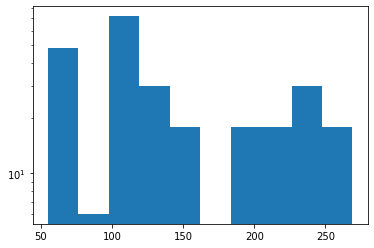

In [19]:
_ = plt.hist(min_par_size, log = True)

performance metrics for merging a partition with only a single node with the rest

In [51]:
perf_metrics.\
  drop(columns = ["par1_size", "par2_size", "F1"]).groupby(["seqlength"]).agg(["min", "max", "mean", "std"])

RF                             runtime                        \
          min max       mean        std       min        max       mean   
seqlength                                                                 
50          8  62  29.534884  16.919063  8.914303  12.489810  10.732290   
100        10  72  28.930233  15.555424  9.001953  12.563638  10.677157   
400         0  48  20.651163  10.847172  8.907304  12.582769  10.717590   
600         4  48  18.697674  10.724993  8.914942  12.546468  10.678425   
800         4  46  21.627907  10.763747  8.960029  12.613173  10.753825   
1000        4  44  15.674419  10.537283  8.946734  12.528035  10.737069   

                     
                std  
seqlength            
50         1.145755  
100        1.148289  
400        1.168563  
600        1.167978  
800        1.184875  
1000       1.173976

## Histogram of RF

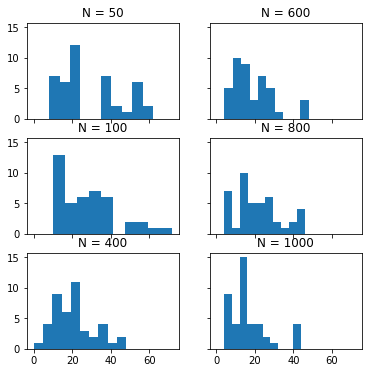

In [44]:
fig, axes = plt.subplots(3, 2, figsize = (6, 6), sharex = True, sharey = True)
for i, seqlen in enumerate(np.unique(perf_metrics.seqlength)):
    #print("seqlength:", i)
    perf_metrics_sub = perf_metrics.loc[(perf_metrics.seqlength == seqlen),:]
    axes[i%3, i//3].hist(perf_metrics_sub.RF)
    axes[i%3, i//3].set_title("N = " + str(seqlen))

In [49]:
RFs_eq_0 = []
for i in np.unique(perf_metrics.seqlength):
    perf_metrics_sub = perf_metrics.loc[(perf_metrics.seqlength == i),:]
    RFs_eq_0.append(np.mean(perf_metrics_sub.RF == 0) * 100)
    
pd.DataFrame({"seqlength": np.unique(perf_metrics.seqlength), 
              "% RF = 0": RFs_eq_0}).round(2)

,seqlength,% RF = 0
0,50,0.00
1,100,0.00
2,400,2.33
3,600,0.00
4,800,0.00
5,1000,0.00


In [50]:
RFs_eq_0 = []
for i in np.unique(perf_metrics.seqlength):
    perf_metrics_sub = perf_metrics.loc[(perf_metrics.seqlength == i),:]
    RFs_eq_0.append(np.mean(perf_metrics_sub.RF < 10) * 100)
    
pd.DataFrame({"seqlength": np.unique(perf_metrics.seqlength), 
              "% RF < 10": RFs_eq_0}).round(2)

,seqlength,% RF < 10
0,50,11.63
1,100,0.00
2,400,11.63
3,600,11.63
4,800,16.28
5,1000,25.58
